# Data Set Description


**VARIABLE NAMES**: DESCRIPTION
* **Encounter ID**	Unique identifier of an encounter
* **Patient number**	Unique identifier of a patient
* **Race**	Values: Caucasian, Asian, African American, Hispanic, and other
* **Gender**	Values: male, female, and unknown/invalid
* **Age**	Grouped in 10-year intervals: 0, 10), 10, 20), …, 90, 100)
* **Weight**	Weight in pounds
* **Admission type**	Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available
* **Discharge disposition**	Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available
* **Admission source**	Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital
* **Time in hospital**	Integer number of days between admission and discharge
* **Payer code**	Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay Medical
* **Medical specialty**	Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon
* **Number of lab procedures**	Number of lab tests performed during the encounter
* **Number of procedures** Numeric	Number of procedures (other than lab tests) performed during the encounter
* **Number of medications**	Number of distinct generic names administered during the encounter
* **Number of outpatient visits** Number of outpatient visits of the patient in the year preceding the encounter
* **Number of emergency visits**	Number of emergency visits of the patient in the year preceding the encounter
* **Number of inpatient visits**	Number of inpatient visits of the patient in the year preceding the encounter
* **Diagnosis 1**	The primary diagnosis (coded as first three digits of ICD9); 848 distinct values
* **Diagnosis 2**	Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values
* **Diagnosis 3** Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values
* **Number of diagnoses**	Number of diagnoses entered to the system 0%
* **Glucose serum test result**	Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured
* **A1c test result**	Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.
* **Change of medications**	Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”
* **Diabetes medications**	Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”
* 24 features for medications	For the generic names: **metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride- pioglitazone, metformin-rosiglitazone, and metformin- pioglitazone**, the feature indicates whether the drug was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed
* **Readmitted**	Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission










# Data Preparation & Exploration 

In [2]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


In [1]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
#loading Dataset
df = pd.read_csv("./data/diabetic/diabetic_data.csv")
df.shape

(101766, 50)

## Dealing with Missing Values
Variable weight contains approximate 98% of the missing values so there is no significance in filling those missing values so we decided to drop these variables. Variable Payer code and medical specialty contains approximate 40% missing values so we also dropped these variables. Variables race, diag_1, diag_2, diag_3 and gender contains very less missing values as compared to other attributes which we dropped so for these attributes we also decided to drop those where missing values contains.

In [8]:
#dropping columns with large number of missing values
df = df.drop(['weight','payer_code','medical_specialty'], axis = 1)
drop_Idx = set(df[(df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')].index)

drop_Idx = drop_Idx.union(set(df['diag_1'][df['diag_1'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_2'][df['diag_2'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_3'][df['diag_3'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['race'][df['race'] == '?'].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 11].index))
drop_Idx = drop_Idx.union(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))
new_Idx = list(set(df.index) - set(drop_Idx))
df = df.iloc[new_Idx]

df = df.drop(['citoglipton', 'examide'], axis = 1)

## Feature Engineering

This is highly subjective, and partly depends on a knowledge of health care services, and making sense of the potential relationships between features. There are perhaps thousands of ways to try here. We tried some...

* Service utilization: The data contains variables for number of inpatient (admissions), emergency room visits and outpatient visits for a given patient in the previous one year. These are (crude) measures of how much hospital/clinic services a person has used in the past year. We added these three to create a new variable called service utilization (see figure below). The idea was to see which version gives us better results. Granted, we did not apply any special weighting to the three ingredients of service utilization but we wanted to try something simple at this stage.



In [12]:
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

* Number of medication changes: The dataset contains 23 features for 23 drugs (or combos) which indicate for each of these, whether a change in that medication was made or not during the current hospital stay of patient. Medication change for diabetics upon admission has been shown by previous research to be associated with lower readmission rates. We decided to count how many changes were made in total for each patient, and declared that a new feature. The reasoning here was to both simplify the model and possibly discover a relationship with number of changes regardless of which drug was changed.

In [13]:
keys = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 
    'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 
    'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 
    'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 
    'tolbutamide', 'acetohexamide'
]
for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
df['numchange'] = 0
for col in keys:
    colname = str(col) + 'temp'
    df['numchange'] = df['numchange'] + df[colname]
    del df[colname]
    
df['numchange'].value_counts()  

numchange
0    70142
1    24922
2     1271
3      106
4        5
Name: count, dtype: int64

In [14]:
# re-encoding admission type, discharge type and admission source into fewer categories

df['admission_type_id'] = df['admission_type_id'].replace(2,1)
df['admission_type_id'] = df['admission_type_id'].replace(7,1)
df['admission_type_id'] = df['admission_type_id'].replace(6,5)
df['admission_type_id'] = df['admission_type_id'].replace(8,5)

df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(6,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(8,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(9,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(13,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(3,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(4,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(5,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(14,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(22,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(23,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(24,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(12,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(15,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(16,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(17,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(25,18)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(26,18)

df['admission_source_id'] = df['admission_source_id'].replace(2,1)
df['admission_source_id'] = df['admission_source_id'].replace(3,1)
df['admission_source_id'] = df['admission_source_id'].replace(5,4)
df['admission_source_id'] = df['admission_source_id'].replace(6,4)
df['admission_source_id'] = df['admission_source_id'].replace(10,4)
df['admission_source_id'] = df['admission_source_id'].replace(22,4)
df['admission_source_id'] = df['admission_source_id'].replace(25,4)
df['admission_source_id'] = df['admission_source_id'].replace(15,9)
df['admission_source_id'] = df['admission_source_id'].replace(17,9)
df['admission_source_id'] = df['admission_source_id'].replace(20,9)
df['admission_source_id'] = df['admission_source_id'].replace(21,9)
df['admission_source_id'] = df['admission_source_id'].replace(13,11)
df['admission_source_id'] = df['admission_source_id'].replace(14,11)

* Encoding some variables: The original dataset used string values for gender, race, medication change, and each of the 23 drugs used. To better fit those variables into our model, we interpret the variables to numeric binary variables to reflect their nature. For example, we encoded the “ medication change ” feature from “No” (no change) and “Ch” (changed) into 0 and 1. 


In [15]:
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)
# keys is the same as before
for col in keys:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)

We also reduced both A1C test result and Glucose serum test result into categories of Normal, Abnormal and Not tested.


In [16]:
df['A1Cresult'] = df['A1Cresult'].replace('>7', 1)
df['A1Cresult'] = df['A1Cresult'].replace('>8', 1)
df['A1Cresult'] = df['A1Cresult'].replace('Norm', 0)
df['A1Cresult'] = df['A1Cresult'].replace('None', -99)
df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('>300', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 0)
df['max_glu_serum'] = df['max_glu_serum'].replace('None', -99)

* Dealing with age: There are different ways to deal with this. The dataset only gives us age as 10 year categories, so we don’t know the exact age of each patient. The previous study on this dataset used age categories as nominal variables, but we wanted to be able to see the effect of increasing age on readmission, even if in a crude way. To do that, we assume that age of the patient on average lies at the midpoint of the age category. For example, if the patient’s age category is 20–30 years, then we assume the age = 25 years. So we converted age categories to midpoints, resulting in a numeric variable:

In [17]:
# code age intervals [0-10) - [90-100) from 1-10
for i in range(0,10):
    df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)
df['age'].value_counts()

age
8     24815
7     21521
6     16546
9     16223
5      9208
4      3538
10     2594
3      1471
2       466
1        64
Name: count, dtype: int64

Collapsing of Multiple Encounters for same patient Some patients in the dataset had more than one encounter.We could not count them as independent encounters because that bias the results towards those patients who had multiple encounters. Thus we tried multiple techniques to collapse and consolidate multiple encounters for same patient such as:

* Considering more than 2 readmissions across multiple encounters as readmission for collapsed record.
* Considering average stay at hospital across multiple encounters.
* Considering the percentage of the medication changes across multiple encounters
* Considering the total number of the encounters to replace the encounter unique ID
* Considering the combination of diagnoses across multiple encounters as a list However, taking the features such as “diagnosis”, for instance, we did not find it not meaningful to combine multiple categorical values into an array for building data model. We then considered first encounter and last encounter separately as possible representations of multiple encounters. However, last encounters gave extremely imbalanced data for readmissions (96/4 Readmissions vs No Readmissions) and thus, we decided to use first encounters of patients with multiple encounters. This resulted in dataset being reduced to about 70,000 encounters:

In [18]:
df2 = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df2.shape
(70442, 55)

(70442, 55)

* Encoding the outcome variable: The outcome we are looking at is whether the patient gets readmitted to the hospital within 30 days or not. The variable actually has < 30, > 30 and No Readmission categories. To reduce our problem to a binary classification, we combined the readmission after 30 days and no readmission into a single category:

In [20]:
df['readmitted'] = df['readmitted'].replace('>30', 0)
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('NO', 0)

* Categorization of diagnoses: The dataset contained up to three diagnoses for a given patient (primary, secondary and additional). However, each of these had 700–900 unique ICD codes and it is extremely difficult to include them in the model and interpret meaningfully. Therefore, we collapsed these diagnosis codes into 9 disease categories in an almost similar fashion to that done in the original publication using this dataset. These 9 categories include Circulatory, Respiratory, Digestive, Diabetes, Injury, Musculoskeletal, Genitourinary, Neoplasms, and Others. Although we did this for primary, secondary and additional diagnoses, we eventually decided to use only the primary diagnosis in our model. Doing this in python was slightly cumbersome because, well, we are mapping the disease codes to certain category names. Below code should demonstrate this easily.

In [23]:
# Creating additional columns for diagnosis# Creati 
df['level1_diag1'] = df['diag_1']
df['level2_diag1'] = df['diag_1']
df['level1_diag2'] = df['diag_2']
df['level2_diag2'] = df['diag_2']
df['level1_diag3'] = df['diag_3']
df['level2_diag3'] = df['diag_3']
df.loc[df['diag_1'].str.contains('V'), ['level1_diag1', 'level2_diag1']] = 0
df.loc[df['diag_1'].str.contains('E'), ['level1_diag1', 'level2_diag1']] = 0
df.loc[df['diag_2'].str.contains('V'), ['level1_diag2', 'level2_diag2']] = 0
df.loc[df['diag_2'].str.contains('E'), ['level1_diag2', 'level2_diag2']] = 0
df.loc[df['diag_3'].str.contains('V'), ['level1_diag3', 'level2_diag3']] = 0
df.loc[df['diag_3'].str.contains('E'), ['level1_diag3', 'level2_diag3']] = 0
df['level1_diag1'] = df['level1_diag1'].replace('?', -1)
df['level2_diag1'] = df['level2_diag1'].replace('?', -1)
df['level1_diag2'] = df['level1_diag2'].replace('?', -1)
df['level2_diag2'] = df['level2_diag2'].replace('?', -1)
df['level1_diag3'] = df['level1_diag3'].replace('?', -1)
df['level2_diag3'] = df['level2_diag3'].replace('?', -1)
df['level1_diag1'] = df['level1_diag1'].astype(float)
df['level2_diag1'] = df['level2_diag1'].astype(float)
df['level1_diag2'] = df['level1_diag2'].astype(float)
df['level2_diag2'] = df['level2_diag2'].astype(float)
df['level1_diag3'] = df['level1_diag3'].astype(float)
df['level2_diag3'] = df['level2_diag3'].astype(float)

for index, row in df.iterrows():
    if (row['level1_diag1'] >= 390 and row['level1_diag1'] < 460) or (np.floor(row['level1_diag1']) == 785):
        df.loc[index, 'level1_diag1'] = 1
    elif (row['level1_diag1'] >= 460 and row['level1_diag1'] < 520) or (np.floor(row['level1_diag1']) == 786):
        df.loc[index, 'level1_diag1'] = 2
    elif (row['level1_diag1'] >= 520 and row['level1_diag1'] < 580) or (np.floor(row['level1_diag1']) == 787):
        df.loc[index, 'level1_diag1'] = 3
    elif (np.floor(row['level1_diag1']) == 250):
        df.loc[index, 'level1_diag1'] = 4
    elif (row['level1_diag1'] >= 800 and row['level1_diag1'] < 1000):
        df.loc[index, 'level1_diag1'] = 5
    elif (row['level1_diag1'] >= 710 and row['level1_diag1'] < 740):
        df.loc[index, 'level1_diag1'] = 6
    elif (row['level1_diag1'] >= 580 and row['level1_diag1'] < 630) or (np.floor(row['level1_diag1']) == 788):
        df.loc[index, 'level1_diag1'] = 7
    elif (row['level1_diag1'] >= 140 and row['level1_diag1'] < 240):
        df.loc[index, 'level1_diag1'] = 8
    else:
        df.loc[index, 'level1_diag1'] = 0
        
    if (row['level1_diag2'] >= 390 and row['level1_diag2'] < 460) or (np.floor(row['level1_diag2']) == 785):
        df.loc[index, 'level1_diag2'] = 1
    elif (row['level1_diag2'] >= 460 and row['level1_diag2'] < 520) or (np.floor(row['level1_diag2']) == 786):
        df.loc[index, 'level1_diag2'] = 2
    elif (row['level1_diag2'] >= 520 and row['level1_diag2'] < 580) or (np.floor(row['level1_diag2']) == 787):
        df.loc[index, 'level1_diag2'] = 3
    elif (np.floor(row['level1_diag2']) == 250):
        df.loc[index, 'level1_diag2'] = 4
    elif (row['level1_diag2'] >= 800 and row['level1_diag2'] < 1000):
        df.loc[index, 'level1_diag2'] = 5
    elif (row['level1_diag2'] >= 710 and row['level1_diag2'] < 740):
        df.loc[index, 'level1_diag2'] = 6
    elif (row['level1_diag2'] >= 580 and row['level1_diag2'] < 630) or (np.floor(row['level1_diag2']) == 788):
        df.loc[index, 'level1_diag2'] = 7
    elif (row['level1_diag2'] >= 140 and row['level1_diag2'] < 240):
        df.loc[index, 'level1_diag2'] = 8
    else:
        df.loc[index, 'level1_diag2'] = 0
    
    if (row['level1_diag3'] >= 390 and row['level1_diag3'] < 460) or (np.floor(row['level1_diag3']) == 785):
        df.loc[index, 'level1_diag3'] = 1
    elif (row['level1_diag3'] >= 460 and row['level1_diag3'] < 520) or (np.floor(row['level1_diag3']) == 786):
        df.loc[index, 'level1_diag3'] = 2
    elif (row['level1_diag3'] >= 520 and row['level1_diag3'] < 580) or (np.floor(row['level1_diag3']) == 787):
        df.loc[index, 'level1_diag3'] = 3
    elif (np.floor(row['level1_diag3']) == 250):
        df.loc[index, 'level1_diag3'] = 4
    elif (row['level1_diag3'] >= 800 and row['level1_diag3'] < 1000):
        df.loc[index, 'level1_diag3'] = 5
    elif (row['level1_diag3'] >= 710 and row['level1_diag3'] < 740):
        df.loc[index, 'level1_diag3'] = 6
    elif (row['level1_diag3'] >= 580 and row['level1_diag3'] < 630) or (np.floor(row['level1_diag3']) == 788):
        df.loc[index, 'level1_diag3'] = 7
    elif (row['level1_diag3'] >= 140 and row['level1_diag3'] < 240):
        df.loc[index, 'level1_diag3'] = 8
    else:
        df.loc[index, 'level1_diag3'] = 0

In [24]:
for index, row in df.iterrows():
    if (row['level2_diag1'] >= 390 and row['level2_diag1'] < 399):
        df.loc[index, 'level2_diag1'] = 1
    elif (row['level2_diag1'] >= 401 and row['level2_diag1'] < 415):
        df.loc[index, 'level2_diag1'] = 2
    elif (row['level2_diag1'] >= 415 and row['level2_diag1'] < 460):
        df.loc[index, 'level2_diag1'] = 3
    elif (np.floor(row['level2_diag1']) == 785):
        df.loc[index, 'level2_diag1'] = 4
    elif (row['level2_diag1'] >= 460 and row['level2_diag1'] < 489):
        df.loc[index, 'level2_diag1'] = 5
    elif (row['level2_diag1'] >= 490 and row['level2_diag1'] < 497):
        df.loc[index, 'level2_diag1'] = 6
    elif (row['level2_diag1'] >= 500 and row['level2_diag1'] < 520):
        df.loc[index, 'level2_diag1'] = 7
    elif (np.floor(row['level2_diag1']) == 786):
        df.loc[index, 'level2_diag1'] = 8
    elif (row['level2_diag1'] >= 520 and row['level2_diag1'] < 530):
        df.loc[index, 'level2_diag1'] = 9
    elif (row['level2_diag1'] >= 530 and row['level2_diag1'] < 544):
        df.loc[index, 'level2_diag1'] = 10
    elif (row['level2_diag1'] >= 550 and row['level2_diag1'] < 554):
        df.loc[index, 'level2_diag1'] = 11
    elif (row['level2_diag1'] >= 555 and row['level2_diag1'] < 580):
        df.loc[index, 'level2_diag1'] = 12
    elif (np.floor(row['level2_diag1']) == 787):
        df.loc[index, 'level2_diag1'] = 13
    elif (np.floor(row['level2_diag1']) == 250):
        df.loc[index, 'level2_diag1'] = 14
    elif (row['level2_diag1'] >= 800 and row['level2_diag1'] < 1000):
        df.loc[index, 'level2_diag1'] = 15
    elif (row['level2_diag1'] >= 710 and row['level2_diag1'] < 740):
        df.loc[index, 'level2_diag1'] = 16
    elif (row['level2_diag1'] >= 580 and row['level2_diag1'] < 630):
        df.loc[index, 'level2_diag1'] = 17
    elif (np.floor(row['level2_diag1']) == 788):
        df.loc[index, 'level2_diag1'] = 18
    elif (row['level2_diag1'] >= 140 and row['level2_diag1'] < 240):
        df.loc[index, 'level2_diag1'] = 19
    elif row['level2_diag1'] >= 240 and row['level2_diag1'] < 280 and (np.floor(row['level2_diag1']) != 250):
        df.loc[index, 'level2_diag1'] = 20
    elif (row['level2_diag1'] >= 680 and row['level2_diag1'] < 710) or (np.floor(row['level2_diag1']) == 782):
        df.loc[index, 'level2_diag1'] = 21
    elif (row['level2_diag1'] >= 290 and row['level2_diag1'] < 320):
        df.loc[index, 'level2_diag1'] = 22
    else:
        df.loc[index, 'level2_diag1'] = 0
        
    if (row['level2_diag2'] >= 390 and row['level2_diag2'] < 399):
        df.loc[index, 'level2_diag2'] = 1
    elif (row['level2_diag2'] >= 401 and row['level2_diag2'] < 415):
        df.loc[index, 'level2_diag2'] = 2
    elif (row['level2_diag2'] >= 415 and row['level2_diag2'] < 460):
        df.loc[index, 'level2_diag2'] = 3
    elif (np.floor(row['level2_diag2']) == 785):
        df.loc[index, 'level2_diag2'] = 4
    elif (row['level2_diag2'] >= 460 and row['level2_diag2'] < 489):
        df.loc[index, 'level2_diag2'] = 5
    elif (row['level2_diag2'] >= 490 and row['level2_diag2'] < 497):
        df.loc[index, 'level2_diag2'] = 6
    elif (row['level2_diag2'] >= 500 and row['level2_diag2'] < 520):
        df.loc[index, 'level2_diag2'] = 7
    elif (np.floor(row['level2_diag2']) == 786):
        df.loc[index, 'level2_diag2'] = 8
    elif (row['level2_diag2'] >= 520 and row['level2_diag2'] < 530):
        df.loc[index, 'level2_diag2'] = 9
    elif (row['level2_diag2'] >= 530 and row['level2_diag2'] < 544):
        df.loc[index, 'level2_diag2'] = 10
    elif (row['level2_diag2'] >= 550 and row['level2_diag2'] < 554):
        df.loc[index, 'level2_diag2'] = 11
    elif (row['level2_diag2'] >= 555 and row['level2_diag2'] < 580):
        df.loc[index, 'level2_diag2'] = 12
    elif (np.floor(row['level2_diag2']) == 787):
        df.loc[index, 'level2_diag2'] = 13
    elif (np.floor(row['level2_diag2']) == 250):
        df.loc[index, 'level2_diag2'] = 14
    elif (row['level2_diag2'] >= 800 and row['level2_diag2'] < 1000):
        df.loc[index, 'level2_diag2'] = 15
    elif (row['level2_diag2'] >= 710 and row['level2_diag2'] < 740):
        df.loc[index, 'level2_diag2'] = 16
    elif (row['level2_diag2'] >= 580 and row['level2_diag2'] < 630):
        df.loc[index, 'level2_diag2'] = 17
    elif (np.floor(row['level2_diag2']) == 788):
        df.loc[index, 'level2_diag2'] = 18
    elif (row['level2_diag2'] >= 140 and row['level2_diag2'] < 240):
        df.loc[index, 'level2_diag2'] = 19
    elif row['level2_diag2'] >= 240 and row['level2_diag2'] < 280 and (np.floor(row['level2_diag2']) != 250):
        df.loc[index, 'level2_diag2'] = 20
    elif (row['level2_diag2'] >= 680 and row['level2_diag2'] < 710) or (np.floor(row['level2_diag2']) == 782):
        df.loc[index, 'level2_diag2'] = 21
    elif (row['level2_diag2'] >= 290 and row['level2_diag2'] < 320):
        df.loc[index, 'level2_diag2'] = 22
    else:
        df.loc[index, 'level2_diag2'] = 0
        
        
    if (row['level2_diag3'] >= 390 and row['level2_diag3'] < 399):
        df.loc[index, 'level2_diag3'] = 1
    elif (row['level2_diag3'] >= 401 and row['level2_diag3'] < 415):
        df.loc[index, 'level2_diag3'] = 2
    elif (row['level2_diag3'] >= 415 and row['level2_diag3'] < 460):
        df.loc[index, 'level2_diag3'] = 3
    elif (np.floor(row['level2_diag3']) == 785):
        df.loc[index, 'level2_diag3'] = 4
    elif (row['level2_diag3'] >= 460 and row['level2_diag3'] < 489):
        df.loc[index, 'level2_diag3'] = 5
    elif (row['level2_diag3'] >= 490 and row['level2_diag3'] < 497):
        df.loc[index, 'level2_diag3'] = 6
    elif (row['level2_diag3'] >= 500 and row['level2_diag3'] < 520):
        df.loc[index, 'level2_diag3'] = 7
    elif (np.floor(row['level2_diag3']) == 786):
        df.loc[index, 'level2_diag3'] = 8
    elif (row['level2_diag3'] >= 520 and row['level2_diag3'] < 530):
        df.loc[index, 'level2_diag3'] = 9
    elif (row['level2_diag3'] >= 530 and row['level2_diag3'] < 544):
        df.loc[index, 'level2_diag3'] = 10
    elif (row['level2_diag3'] >= 550 and row['level2_diag3'] < 554):
        df.loc[index, 'level2_diag3'] = 11
    elif (row['level2_diag3'] >= 555 and row['level2_diag3'] < 580):
        df.loc[index, 'level2_diag3'] = 12
    elif (np.floor(row['level2_diag3']) == 787):
        df.loc[index, 'level2_diag3'] = 13
    elif (np.floor(row['level2_diag3']) == 250):
        df.loc[index, 'level2_diag3'] = 14
    elif (row['level2_diag3'] >= 800 and row['level2_diag3'] < 1000):
        df.loc[index, 'level2_diag3'] = 15
    elif (row['level2_diag3'] >= 710 and row['level2_diag3'] < 740):
        df.loc[index, 'level2_diag3'] = 16
    elif (row['level2_diag3'] >= 580 and row['level2_diag3'] < 630):
        df.loc[index, 'level2_diag3'] = 17
    elif (np.floor(row['level2_diag3']) == 788):
        df.loc[index, 'level2_diag3'] = 18
    elif (row['level2_diag3'] >= 140 and row['level2_diag3'] < 240):
        df.loc[index, 'level2_diag3'] = 19
    elif row['level2_diag3'] >= 240 and row['level2_diag3'] < 280 and (np.floor(row['level2_diag3']) != 250):
        df.loc[index, 'level2_diag3'] = 20
    elif (row['level2_diag3'] >= 680 and row['level2_diag3'] < 710) or (np.floor(row['level2_diag3']) == 782):
        df.loc[index, 'level2_diag3'] = 21
    elif (row['level2_diag3'] >= 290 and row['level2_diag3'] < 320):
        df.loc[index, 'level2_diag3'] = 22
    else:
        df.loc[index, 'level2_diag3'] = 0

In [25]:
df['age'] = df['age'].astype('int64')
print(df.age.value_counts())
# convert age categories to mid-point values
age_dict = {1:5, 2:15, 3:25, 4:35, 5:45, 6:55, 7:65, 8:75, 9:85, 10:95}
df['age'] = df.age.map(age_dict)
print(df.age.value_counts())

age
8     24815
7     21521
6     16546
9     16223
5      9208
4      3538
10     2594
3      1471
2       466
1        64
Name: count, dtype: int64
age
75    24815
65    21521
55    16546
85    16223
45     9208
35     3538
95     2594
25     1471
15      466
5        64
Name: count, dtype: int64


In [26]:
# convert data type of nominal features in dataframe to 'object' type
i = ['encounter_id', 'patient_nbr', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',\
          'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', \
          'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', \
          'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', \
          'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', \
          'age', 'A1Cresult', 'max_glu_serum', 'level1_diag1', 'level1_diag2', 'level1_diag3', 'level2_diag1', 'level2_diag2', 'level2_diag3']

df[i] = df[i].astype('object')

ValueError: Columns must be same length as key

In [27]:
df.dtypes

encounter_id                 object
patient_nbr                  object
race                         object
gender                       object
age                           int64
admission_type_id            object
discharge_disposition_id     object
admission_source_id          object
time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses              int64
max_glu_serum               float64
A1Cresult                   float64
metformin                     int64
repaglinide                   int64
nateglinide                   int64
chlorpropamide                int64
glimepiride                   int64
acetohexamide                 int64
glipizide                   

* Number of medication used: Another possibly related factor could be the total number of medications used by the patient (which may indicate severity of their condition and/or the intensity of care). So we created another feature by counting the medications used during the encounter (keys variable in code below is continued from above):

In [28]:
df['nummed'] = 0

for col in keys:
    df['nummed'] = df['nummed'] + df[col]
df['nummed'].value_counts()

nummed
1    44589
0    22156
2    20901
3     7448
4     1290
5       57
6        5
Name: count, dtype: int64

In [29]:
# get list of only numeric features
num_col = list(set(list(df._get_numeric_data().columns))- {'readmitted'})
num_col

['level2_diag1',
 'tolbutamide',
 'metformin-rosiglitazone',
 'glimepiride',
 'level2_diag2',
 'diabetesMed',
 'age',
 'glipizide',
 'level1_diag2',
 'number_emergency',
 'pioglitazone',
 'service_utilization',
 'num_medications',
 'change',
 'nateglinide',
 'A1Cresult',
 'glyburide',
 'number_inpatient',
 'glimepiride-pioglitazone',
 'metformin-pioglitazone',
 'level1_diag3',
 'nummed',
 'miglitol',
 'glyburide-metformin',
 'acarbose',
 'rosiglitazone',
 'numchange',
 'chlorpropamide',
 'level1_diag1',
 'acetohexamide',
 'level2_diag3',
 'glipizide-metformin',
 'insulin',
 'time_in_hospital',
 'max_glu_serum',
 'tolazamide',
 'num_procedures',
 'number_outpatient',
 'metformin',
 'troglitazone',
 'num_lab_procedures',
 'number_diagnoses',
 'repaglinide']

In [30]:
# Removing skewnewss and kurtosis using log transformation if it is above a threshold value -  2

statdataframe = pd.DataFrame()
statdataframe['numeric_column'] = num_col
skew_before = []
skew_after = []

kurt_before = []
kurt_after = []

standard_deviation_before = []
standard_deviation_after = []

log_transform_needed = []

log_type = []

for i in num_col:
    skewval = df[i].skew()
    skew_before.append(skewval)
    
    kurtval = df[i].kurtosis()
    kurt_before.append(kurtval)
    
    sdval = df[i].std()
    standard_deviation_before.append(sdval)
    
    if (abs(skewval) >2) & (abs(kurtval) >2):
        log_transform_needed.append('Yes')
        
        if len(df[df[i] == 0])/len(df) <=0.02:
            log_type.append('log')
            skewvalnew = np.log(pd.DataFrame(df[train_data[i] > 0])[i]).skew()
            skew_after.append(skewvalnew)
            
            kurtvalnew = np.log(pd.DataFrame(df[train_data[i] > 0])[i]).kurtosis()
            kurt_after.append(kurtvalnew)
            
            sdvalnew = np.log(pd.DataFrame(df[train_data[i] > 0])[i]).std()
            standard_deviation_after.append(sdvalnew)
            
        else:
            log_type.append('log1p')
            skewvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).skew()
            skew_after.append(skewvalnew)
        
            kurtvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).kurtosis()
            kurt_after.append(kurtvalnew)
            
            sdvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).std()
            standard_deviation_after.append(sdvalnew)
            
    else:
        log_type.append('NA')
        log_transform_needed.append('No')
        
        skew_after.append(skewval)
        kurt_after.append(kurtval)
        standard_deviation_after.append(sdval)

statdataframe['skew_before'] = skew_before
statdataframe['kurtosis_before'] = kurt_before
statdataframe['standard_deviation_before'] = standard_deviation_before
statdataframe['log_transform_needed'] = log_transform_needed
statdataframe['log_type'] = log_type
statdataframe['skew_after'] = skew_after
statdataframe['kurtosis_after'] = kurt_after
statdataframe['standard_deviation_after'] = standard_deviation_after

In [32]:
# performing the log transformation for the columns determined to be needing it above.

for i in range(len(statdataframe)):
    if statdataframe['log_transform_needed'][i] == 'Yes':
        colname = str(statdataframe['numeric_column'][i])
        
        if statdataframe['log_type'][i] == 'log':
            df = df[df[colname] > 0]
            df[colname + "_log"] = np.log(df[colname])
            
        elif statdataframe['log_type'][i] == 'log1p':
            df = df[df[colname] >= 0]
            df[colname + "_log1p"] = np.log1p(df[colname])

In [33]:
df = df.drop(['number_outpatient', 'number_inpatient', 'number_emergency','service_utilization'], axis = 1)

In [34]:
df.shape

(96446, 72)

In [35]:
# get list of only numeric features
numerics = list(set(list(df._get_numeric_data().columns))- {'readmitted'})
numerics

['level2_diag1',
 'tolbutamide',
 'metformin-rosiglitazone',
 'glimepiride',
 'level2_diag2',
 'diabetesMed',
 'age',
 'glimepiride_log1p',
 'glipizide',
 'level1_diag2',
 'number_outpatient_log1p',
 'pioglitazone',
 'number_inpatient_log1p',
 'repaglinide_log1p',
 'num_medications',
 'change',
 'nateglinide',
 'A1Cresult',
 'glyburide',
 'glimepiride-pioglitazone',
 'metformin-pioglitazone',
 'level1_diag3',
 'nummed',
 'nateglinide_log1p',
 'glimepiride-pioglitazone_log1p',
 'troglitazone_log1p',
 'miglitol',
 'glyburide-metformin',
 'tolazamide_log1p',
 'acarbose',
 'rosiglitazone',
 'numchange',
 'glipizide_log1p',
 'chlorpropamide',
 'glyburide-metformin_log1p',
 'level1_diag1',
 'acetohexamide',
 'level2_diag3',
 'pioglitazone_log1p',
 'glipizide-metformin',
 'miglitol_log1p',
 'insulin',
 'time_in_hospital',
 'tolbutamide_log1p',
 'max_glu_serum',
 'glyburide_log1p',
 'tolazamide',
 'num_procedures',
 'chlorpropamide_log1p',
 'rosiglitazone_log1p',
 'metformin',
 'troglitazone',

In [36]:
# show list of features that are categorical
df.encounter_id = df.encounter_id.astype('int64')
df.patient_nbr = df.patient_nbr.astype('int64')
df.diabetesMed = df.diabetesMed.astype('int64')
df.change = df.change.astype('int64')

# convert data type of nominal features in dataframe to 'object' type for aggregating
i = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', \
          'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', \
          'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', \
          'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone','A1Cresult']
df[i] = df[i].astype('int64')

df.dtypes

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [37]:
dfcopy = df.copy(deep = True)

In [38]:
df['readmitted'] = df['readmitted'].apply(lambda x: 0 if x == 2 else x)

In [39]:
# drop individual diagnosis columns that have too granular disease information
# also drop level 2 categorization (which was not comparable with any reference)
# also drop level 1 secondary and tertiary diagnoses
df.drop(['diag_1', 'diag_2', 'diag_3', 'level2_diag1', 'level1_diag2', 'level2_diag2', 'level1_diag3',
         'level2_diag3'], axis=1, inplace=True)

In [40]:
interactionterms = [('num_medications','time_in_hospital'),
('num_medications','num_procedures'),
('time_in_hospital','num_lab_procedures'),
('num_medications','num_lab_procedures'),
('num_medications','number_diagnoses'),
('age','number_diagnoses'),
('change','num_medications'),
('number_diagnoses','time_in_hospital'),
('num_medications','numchange')]

In [41]:
for inter in interactionterms:
    name = inter[0] + '|' + inter[1]
    df[name] = df[inter[0]] * df[inter[1]]

In [42]:
df[['num_medications','time_in_hospital', 'num_medications|time_in_hospital']].head()

,num_medications,time_in_hospital,num_medications|time_in_hospital
1,18,3,54
2,13,2,26
3,16,2,32
4,8,1,8
5,16,3,48


In [43]:
# Feature Scaling
datf = pd.DataFrame()
datf['features'] = numerics
datf['std_dev'] = datf['features'].apply(lambda x: df[x].std())
datf['mean'] = datf['features'].apply(lambda x: df[x].mean())

KeyError: 'level2_diag1'

In [44]:
# dropping multiple encounters while keeping either first or last encounter of these patients
df2 = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df2.shape

(67580, 73)

In [45]:
# standardize function
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [46]:
df2[numerics] = standardize(df2[numerics])
import scipy as sp
df2 = df2[(np.abs(sp.stats.zscore(df2[numerics])) < 3).all(axis=1)]

KeyError: "['level2_diag1', 'level2_diag2', 'level1_diag2', 'level1_diag3', 'level2_diag3'] not in index"

In [61]:
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())
table = df2.drop(['patient_nbr', 'encounter_id'], axis=1).corr(method='pearson')
table.style.background_gradient(cmap=my_cmap, axis = 0)

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [62]:
df2['level1_diag1'] = df2['level1_diag1'].astype('object')
df_pd = pd.get_dummies(df2, columns=['gender', 'admission_type_id', 'discharge_disposition_id',
                                      'admission_source_id', 'max_glu_serum', 'A1Cresult', 'level1_diag1'], drop_first = True)
just_dummies = pd.get_dummies(df_pd['race'])
df_pd = pd.concat([df_pd, just_dummies], axis=1)      
df_pd.drop(['race'], inplace=True, axis=1)

In [63]:
non_num_cols = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
                'max_glu_serum', 'A1Cresult', 'level1_diag1' ]

In [64]:
num_cols = list(set(list(df._get_numeric_data().columns))- {'readmitted', 'change'})
num_cols

['num_medications|time_in_hospital',
 'num_medications|num_procedures',
 'time_in_hospital',
 'num_medications|numchange',
 'metformin',
 'encounter_id',
 'insulin',
 'service_utilization_log1p',
 'repaglinide',
 'acetohexamide',
 'pioglitazone',
 'time_in_hospital|num_lab_procedures',
 'numchange',
 'nateglinide',
 'glipizide-metformin',
 'num_procedures',
 'num_medications',
 'A1Cresult',
 'number_inpatient_log1p',
 'num_lab_procedures',
 'number_diagnoses',
 'glyburide-metformin',
 'rosiglitazone',
 'number_diagnoses|time_in_hospital',
 'glimepiride-pioglitazone',
 'num_medications|number_diagnoses',
 'num_medications|num_lab_procedures',
 'number_emergency_log1p',
 'patient_nbr',
 'acarbose',
 'miglitol',
 'metformin-pioglitazone',
 'tolbutamide',
 'glipizide',
 'glyburide',
 'number_outpatient_log1p',
 'glimepiride',
 'metformin-rosiglitazone',
 'chlorpropamide',
 'troglitazone',
 'diabetesMed',
 'tolazamide',
 'change|num_medications']

In [65]:
new_non_num_cols = []
for i in non_num_cols:
    for j in df_pd.columns:
        if i in j:
            new_non_num_cols.append(j)

In [66]:
new_non_num_cols

['gender_1',
 'admission_type_id_3',
 'admission_type_id_4',
 'admission_type_id_5',
 'discharge_disposition_id_2',
 'discharge_disposition_id_7',
 'discharge_disposition_id_10',
 'discharge_disposition_id_18',
 'discharge_disposition_id_19',
 'discharge_disposition_id_20',
 'discharge_disposition_id_27',
 'discharge_disposition_id_28',
 'admission_source_id_4',
 'admission_source_id_7',
 'admission_source_id_8',
 'admission_source_id_9',
 'admission_source_id_11',
 'max_glu_serum_0',
 'max_glu_serum_1',
 'A1Cresult_0',
 'A1Cresult_1',
 'level1_diag1_1.0',
 'level1_diag1_2.0',
 'level1_diag1_3.0',
 'level1_diag1_4.0',
 'level1_diag1_5.0',
 'level1_diag1_6.0',
 'level1_diag1_7.0',
 'level1_diag1_8.0']

In [67]:
l = []
for feature in list(df_pd.columns):
    if '|' in feature:
        l.append(feature)
l

['num_medications|time_in_hospital',
 'num_medications|num_procedures',
 'time_in_hospital|num_lab_procedures',
 'num_medications|num_lab_procedures',
 'num_medications|number_diagnoses',
 'age|number_diagnoses',
 'change|num_medications',
 'number_diagnoses|time_in_hospital',
 'num_medications|numchange']

In [68]:
df_pd.head().T

,1,2,3,4,5
encounter_id,149190,64410,500364,16680,35754
patient_nbr,55629189,86047875,82442376,42519267,82637451
age,15,25,35,45,55
time_in_hospital,-0.444872,-0.784109,-0.784109,-1.12335,-0.444872
num_lab_procedures,0.803605,-1.60206,0.0518349,0.402661,-0.5997
num_procedures,-0.816784,2.02679,-0.24807,-0.816784,2.5955
num_medications,0.270081,-0.335198,0.0279693,-0.940477,0.0279693
number_diagnoses,0.881754,-0.704844,-0.175978,-1.23371,0.881754
metformin,0,0,0,0,0
repaglinide,0,0,0,0,0


## Modeling

In [69]:
feature_set = ['age', 'time_in_hospital', 'num_procedures', 'num_medications', 'number_outpatient_log1p', 
                 'number_emergency_log1p', 'number_inpatient_log1p', 'number_diagnoses', 'metformin', 
                 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
                 'pioglitazone', 'rosiglitazone', 'acarbose', 'tolazamide', 'insulin', 'glyburide-metformin',
                 'AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Other', 'gender_1', 
                 'admission_type_id_3', 'admission_type_id_5', 'discharge_disposition_id_2', 'discharge_disposition_id_7', 
                 'discharge_disposition_id_10', 'discharge_disposition_id_18', 'admission_source_id_4',
                 'admission_source_id_7', 'admission_source_id_9', 'max_glu_serum_0', 'max_glu_serum_1', 'A1Cresult_0',
                 'A1Cresult_1', 'num_medications|time_in_hospital', 'num_medications|num_procedures',
                 'time_in_hospital|num_lab_procedures', 'num_medications|num_lab_procedures', 'num_medications|number_diagnoses',
                 'age|number_diagnoses', 'change|num_medications', 'number_diagnoses|time_in_hospital',
                 'num_medications|numchange', 'level1_diag1_1.0', 'level1_diag1_2.0', 'level1_diag1_3.0', 'level1_diag1_4.0',
                 'level1_diag1_5.0','level1_diag1_6.0', 'level1_diag1_7.0', 'level1_diag1_8.0']

In [70]:
X = df_pd[feature_set]
y = df_pd['readmitted']

### Logistic Regression

In [71]:
df_pd['readmitted'].value_counts()

0    54635
1     5071
Name: readmitted, dtype: int64

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
logit = LogisticRegression(fit_intercept=True, penalty='l1')
logit.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [73]:
logit_pred = logit.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(logit_pred, name = 'Predict'), margins = True)

Predict,0,All
Actual,,
0,1466,1466
1,167,167
All,1633,1633


In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, logit_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, logit_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, logit_pred)))

Accuracy is 0.91
Precision is 0.00
Recall is 0.00


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Since our target variable is having class imbalance problem, So will use SMOTE technique to resolve it


In [75]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
sm = SMOTE(random_state=20)
train_input_new, train_output_new = sm.fit_sample(X_train, y_train)
print('New dataset shape {}'.format(Counter(train_output_new)))

Using TensorFlow backend.


Original dataset shape Counter({0: 43711, 1: 4053})
New dataset shape Counter({0: 43711, 1: 43711})


In [76]:
train_input_new = pd.DataFrame(train_input_new, columns = list(X.columns))
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=0)
logit = LogisticRegression(fit_intercept=True, penalty='l1')
logit.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [77]:
logit_pred = logit.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(logit_pred, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,5805,2901,8706
1,3895,4884,8779
All,9700,7785,17485


In [78]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, logit_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, logit_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, logit_pred)))

accuracy_logit = accuracy_score(y_test, logit_pred)
precision_logit = precision_score(y_test, logit_pred)
recall_logit = recall_score(y_test, logit_pred)

Accuracy is 0.61
Precision is 0.63
Recall is 0.56


### Decision Tree

In [79]:
feature_set_no_int = ['age', 'time_in_hospital', 'num_procedures', 'num_medications', 'number_outpatient_log1p', 
                 'number_emergency_log1p', 'number_inpatient_log1p', 'number_diagnoses', 'metformin', 
                 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 
                 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
                 'tolazamide', 'insulin', 'glyburide-metformin',
                 'AfricanAmerican', 'Asian', 'Caucasian', 
                 'Hispanic', 'Other', 'gender_1', 
                 'admission_type_id_3', 'admission_type_id_5', 
                 'discharge_disposition_id_2', 'discharge_disposition_id_7', 
                 'discharge_disposition_id_10', 'discharge_disposition_id_18', 
                 'admission_source_id_4', 'admission_source_id_7', 
                 'admission_source_id_9', 'max_glu_serum_0', 
                 'max_glu_serum_1', 'A1Cresult_0', 'A1Cresult_1', 
                 'level1_diag1_1.0',
                 'level1_diag1_2.0',
                 'level1_diag1_3.0',
                 'level1_diag1_4.0',
                 'level1_diag1_5.0',
                 'level1_diag1_6.0',
                 'level1_diag1_7.0',
                 'level1_diag1_8.0']

In [80]:
X = df_pd[feature_set_no_int]
y = df_pd['readmitted']
df_pd['readmitted'].value_counts()

0    54635
1     5071
Name: readmitted, dtype: int64

In [81]:
print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTE(random_state=20)
train_input_new, train_output_new = smt.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(train_output_new)))
train_input_new = pd.DataFrame(train_input_new, columns = list(X.columns))
X_train, X_test, y_train, y_test = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=0)

Original dataset shape Counter({0: 54635, 1: 5071})
New dataset shape Counter({0: 54635, 1: 54635})


In [82]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=28,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [83]:
dtree_pred = dtree.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(dtree_pred, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,10244,692,10936
1,1130,9788,10918
All,11374,10480,21854


In [84]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, dtree_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, dtree_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, dtree_pred)))

accuracy_dtree = accuracy_score(y_test, dtree_pred)
precision_dtree = precision_score(y_test, dtree_pred)
recall_dtree = recall_score(y_test, dtree_pred)

Accuracy is 0.92
Precision is 0.93
Recall is 0.90


                       Feature  Importance
8                    metformin    0.022040
19                     insulin    0.022958
26                    gender_1    0.023195
0                          age    0.026882
40            level1_diag1_1.0    0.029614
2               num_procedures    0.043294
3              num_medications    0.048912
7             number_diagnoses    0.077183
29  discharge_disposition_id_2    0.106147
1             time_in_hospital    0.413369


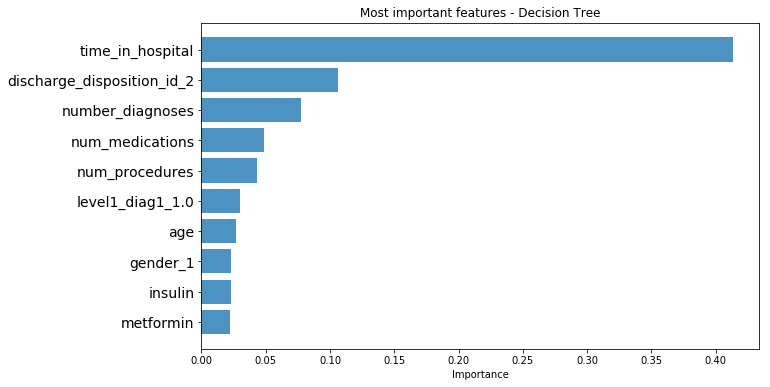

In [85]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = dtree.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree')
plt.show()

### Random Forest

In [86]:
X = df_pd[feature_set_no_int]
y = df_pd['readmitted']

print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTE(random_state=20)
train_input_new, train_output_new = smt.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(train_output_new)))
train_input_new = pd.DataFrame(train_input_new, columns = list(X.columns))
X_train, X_test, y_train, y_test = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=0)

Original dataset shape Counter({0: 54635, 1: 5071})
New dataset shape Counter({0: 54635, 1: 54635})


In [87]:
from sklearn.ensemble import RandomForestClassifier
rm = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rm.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
rm_prd = rm.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(rm_prd, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,10795,141,10936
1,1141,9777,10918
All,11936,9918,21854


In [89]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, rm_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test, rm_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test, rm_prd)))

accuracy_rm = accuracy_score(y_test, rm_prd)
precision_rm = precision_score(y_test, rm_prd)
recall_rm = recall_score(y_test, rm_prd)

Accuracy is 0.94
Precision is 0.99
Recall is 0.90


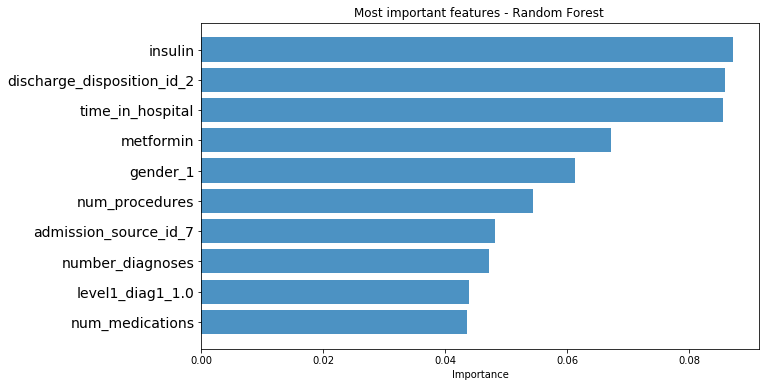

In [90]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = rm.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

## Model Comparision

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


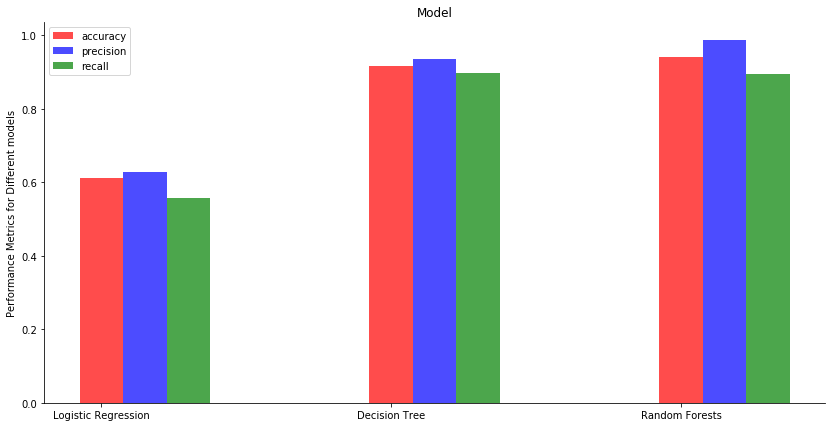

In [91]:
plt.figure(figsize=(14, 7))
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests']
values = [accuracy_logit, accuracy_dtree, accuracy_rm]
model = np.arange(len(models))

plt.bar(model, values, align='center', width = 0.15, alpha=0.7, color = 'red', label= 'accuracy')
plt.xticks(model, models)
           

           
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests']
values = [precision_logit, precision_dtree, precision_rm]
model = np.arange(len(models))

plt.bar(model+0.15, values, align='center', width = 0.15, alpha=0.7, color = 'blue', label = 'precision')
plt.xticks(model, models)



ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests' ]
values = [recall_logit, recall_dtree, recall_rm, ]
model = np.arange(len(models))

plt.bar(model+0.3, values, align='center', width = 0.15, alpha=0.7, color = 'green', label = 'recall')
plt.xticks(model, models)



plt.ylabel('Performance Metrics for Different models')
plt.title('Model')
    
# removing the axis on the top and right of the plot window
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

plt.show()           